In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
import os
import sys

# Add the project root to sys.path
sys.path.append(os.path.abspath(".."))
from chapters.utils import make_train_step, make_validation_step, mini_batch, plot_losses

version = "v2"
os.makedirs(version, exist_ok=True)
data_prep = f"{version}/data_preparation.py"
model_config = f"{version}/model_config.py"
model_train = f"{version}/model_training.py"

In [17]:
%%writefile $data_prep
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

class Custom_dataset(Dataset):
    def __init__(self, features, labels):
        self.x = features
        self.y = labels

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# w = torch.randn(1, device=device, requires_grad=True, dtype=torch.float)
# b = torch.randn(1, device=device, requires_grad=True, dtype=torch.float)
w = 0.5
b = 1.2

# x = torch.linspace(0, 1, 100).to(device)
# this time not sending to gpu as we don't want to load the whole data in gpu memory
x = torch.linspace(0, 1, 100)
# y = (w * x + b).detach()
y = (w * x + b)

# x_train, x_test, y_train, y_test = train_test_split(
#     x, y, test_size=0.2, random_state=42, shuffle=True
# )

dataset = Custom_dataset(x, y)

n_train = int(len(dataset) * 0.8)
n_val = len(dataset) - n_train

train_data, validation_data = random_split(dataset=dataset, lengths=[n_train, n_val])

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=16, shuffle=True)


Overwriting v2/data_preparation.py


In [18]:
%%writefile $model_config
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
lr = 0.1

class Linear_regression_model_class(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(1,1)

  def forward(self, x):
    return self.linear(x)

model = Linear_regression_model_class().to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
train_fn = make_train_step(model, loss_fn, optimizer)
validation_fn = make_validation_step(model, loss_fn, optimizer)

Overwriting v2/model_config.py


In [ ]:
%%writefile $model_train
epochs = 30
train_losses = []
validation_losses = []

for epoch in range(epochs):
  train_loss = mini_batch(device=device, dataloader=train_loader, step_fn=train_fn)
  train_losses.append(train_loss)
  with torch.no_grad():
    validation_loss = mini_batch(device=device, dataloader=validation_loader, step_fn=validation_fn)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

print(model.state_dict())

plot_losses({
  "train loss": train_losses,
  "validation loss": validation_losses
})

# in terminal write "tensorboard --logdir="chapters/runs"" to run tensorboard
writer = SummaryWriter(log_dir='runs/test')
dummy_x, dummy_y = next(iter(train_loader))
writer.add_graph(model, dummy_x.unsqueeze(1).to(device))

Overwriting v2/model_training.py


OrderedDict({'linear.weight': tensor([[0.5000]], device='cuda:0'), 'linear.bias': tensor([1.1998], device='cuda:0')})


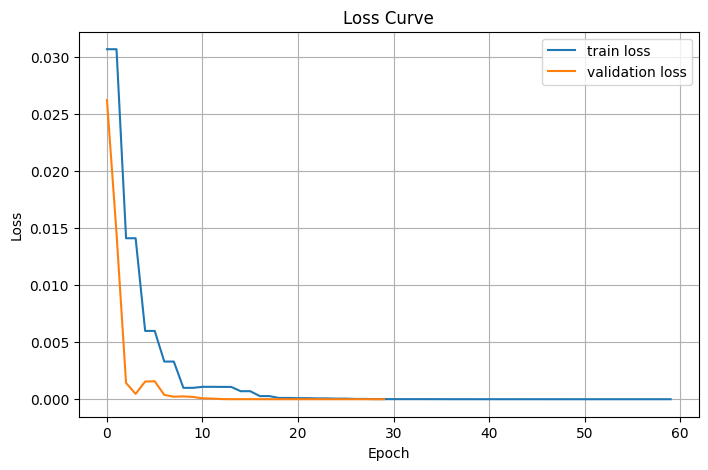

In [20]:
%run -i $data_prep
%run -i $model_config
%run -i $model_train